In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn

In [2]:
#load our train dataset.
train = pd.read_csv("~/datasets/mnist/train.csv")

In [3]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
#Splitting train dataset into X and Y.Normalizing it by dividing it with 255
X = train.iloc[:,1:].values / 255
Y = train.iloc[:,0].values

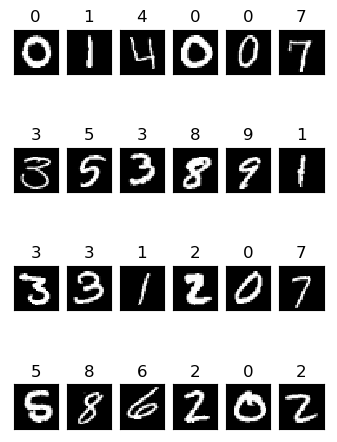

In [5]:
#visulaizing numbers in our dataset.
r = 4
c = 6
fig=plt.figure(figsize=(r, c),dpi=100)
for i in range(1, r*c+1):
    img = X[i].reshape(28,28)
    ax = fig.add_subplot(r, c, i)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.title.set_text(Y[i])
    
    plt.imshow(img,cmap='gray')
plt.show()

In [6]:
from sklearn.model_selection import train_test_split

trn_x,val_x,trn_y,val_y = train_test_split(X,Y,test_size=0.2)

In [7]:
import mxnet as mx
from mxnet import nd, gluon, autograd
from mxnet.gluon import nn
import mxnet.ndarray as F

class Net(gluon.Block):
    def __init__(self, **kwargs):
        super(Net, self).__init__(**kwargs)
        with self.name_scope():
            
            self.fc1 = nn.Dense(784)
            self.fc2 = nn.Dense(128)
            self.out = nn.Dense(10)
            
    def forward(self,x):
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)
        
        return x
    
mlp = Net()
print(mlp)

Net(
  (fc1): Dense(None -> 784, linear)
  (fc2): Dense(None -> 128, linear)
  (out): Dense(None -> 10, linear)
)


In [8]:
device = mx.gpu(0) if mx.context.num_gpus() > 0 else mx.cpu(0)
mlp.initialize(mx.init.Xavier(), ctx=device)

In [9]:
trainer = gluon.Trainer(
    params=mlp.collect_params(),
    optimizer='adam',
    optimizer_params={'learning_rate': 0.01},
)

In [10]:
accuracy_fn = mx.metric.Accuracy()
loss_function = gluon.loss.SoftmaxCrossEntropyLoss()
ce_loss = mx.metric.CrossEntropy()

In [11]:
#converting our numpy array into mxnet.nd.array

trn_x = nd.array(trn_x)
trn_y = nd.array(trn_y)

val_x = nd.array(val_x)
val_y = nd.array(val_y)

In [12]:
def reset_metrics():
    accuracy_fn.reset()
    ce_loss.reset()

In [13]:
EPOCHS = 12
trn_loss = []
val_loss = []

for epoch in range(EPOCHS):
    
    train_iter = mx.io.NDArrayIter(trn_x, trn_y, 1000, shuffle=True)
    val_iter = mx.io.NDArrayIter(val_x, val_y, 1000, shuffle=True)
    
    for trn_batch,val_batch in zip(train_iter,val_iter):
        x = trn_batch.data[0].as_in_context(device)
        y = trn_batch.label[0].as_in_context(device)
        
        vx = trn_batch.data[0].as_in_context(device)
        vy = trn_batch.label[0].as_in_context(device)
        
        with autograd.record():
            y_pred = mlp(x)
            loss = loss_function(y_pred, y)
            
        accuracy_fn.update(y,y_pred)
        ce_loss.update(y,F.softmax(y_pred))
        
        _,training_acc = accuracy_fn.get()
        _,training_loss = ce_loss.get()
    
        trn_loss.append(training_loss)
        reset_metrics()
        
        #backprop
        loss.backward()
    
        trainer.step(batch_size=trn_x.shape[0])
             
        #computing validation loss
        y_pred = mlp(vx)
        
        accuracy_fn.update(vy,y_pred)
        ce_loss.update(vy,F.softmax(y_pred))
        
        _,validation_acc = accuracy_fn.get()
        _,validation_loss = ce_loss.get()
    
        val_loss.append(validation_loss)
        reset_metrics()
        
    
        
    print("epoch: {} | trn_loss: {} | trn_acc: {} | val_loss: {}".format(
                                                        epoch+1,
                                                        trn_loss[-1],
                                                        training_acc,
                                                        val_loss[-1]))
            

epoch: 1 | trn_loss: 0.8864202270507813 | trn_acc: 0.692 | val_loss: 0.7262200927734375
epoch: 2 | trn_loss: 0.39387701416015625 | trn_acc: 0.89 | val_loss: 0.3728387451171875
epoch: 3 | trn_loss: 0.27791278076171877 | trn_acc: 0.91 | val_loss: 0.2531790008544922
epoch: 4 | trn_loss: 0.18025076293945314 | trn_acc: 0.95 | val_loss: 0.16325555419921875
epoch: 5 | trn_loss: 0.17054116821289061 | trn_acc: 0.951 | val_loss: 0.1530576171875
epoch: 6 | trn_loss: 0.1597889862060547 | trn_acc: 0.951 | val_loss: 0.14149189758300781
epoch: 7 | trn_loss: 0.10743430328369141 | trn_acc: 0.962 | val_loss: 0.10027960205078125
epoch: 8 | trn_loss: 0.1211449203491211 | trn_acc: 0.968 | val_loss: 0.10203709411621094
epoch: 9 | trn_loss: 0.08862917327880859 | trn_acc: 0.971 | val_loss: 0.0732969207763672
epoch: 10 | trn_loss: 0.05035507202148438 | trn_acc: 0.984 | val_loss: 0.04794781494140625
epoch: 11 | trn_loss: 0.07531783294677734 | trn_acc: 0.973 | val_loss: 0.060168010711669925
epoch: 12 | trn_loss:

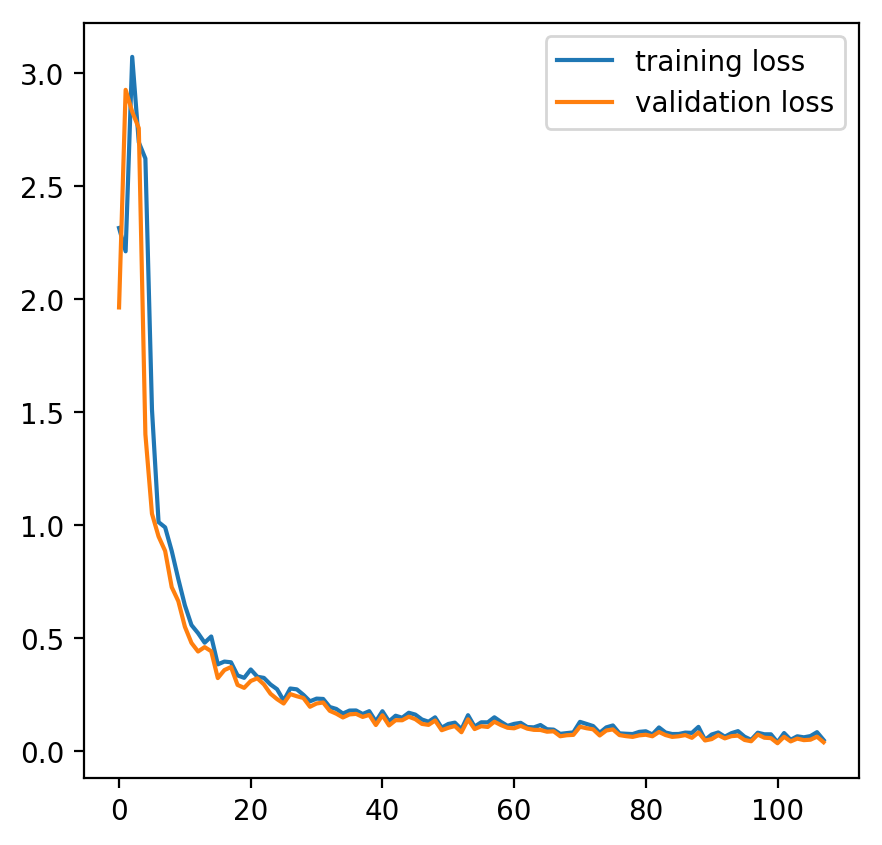

In [14]:
plt.figure(figsize=(5,5),dpi=200)
plt.plot(trn_loss,label='training loss')
plt.plot(val_loss,label='validation loss')
plt.legend(loc='upper right')

In [15]:
pred = mlp(val_x.as_in_context(device))
predictions = []

for p in pred.asnumpy():
    predictions.append(np.argmax(p,axis=0))

In [16]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(val_y.asnumpy(),predictions)

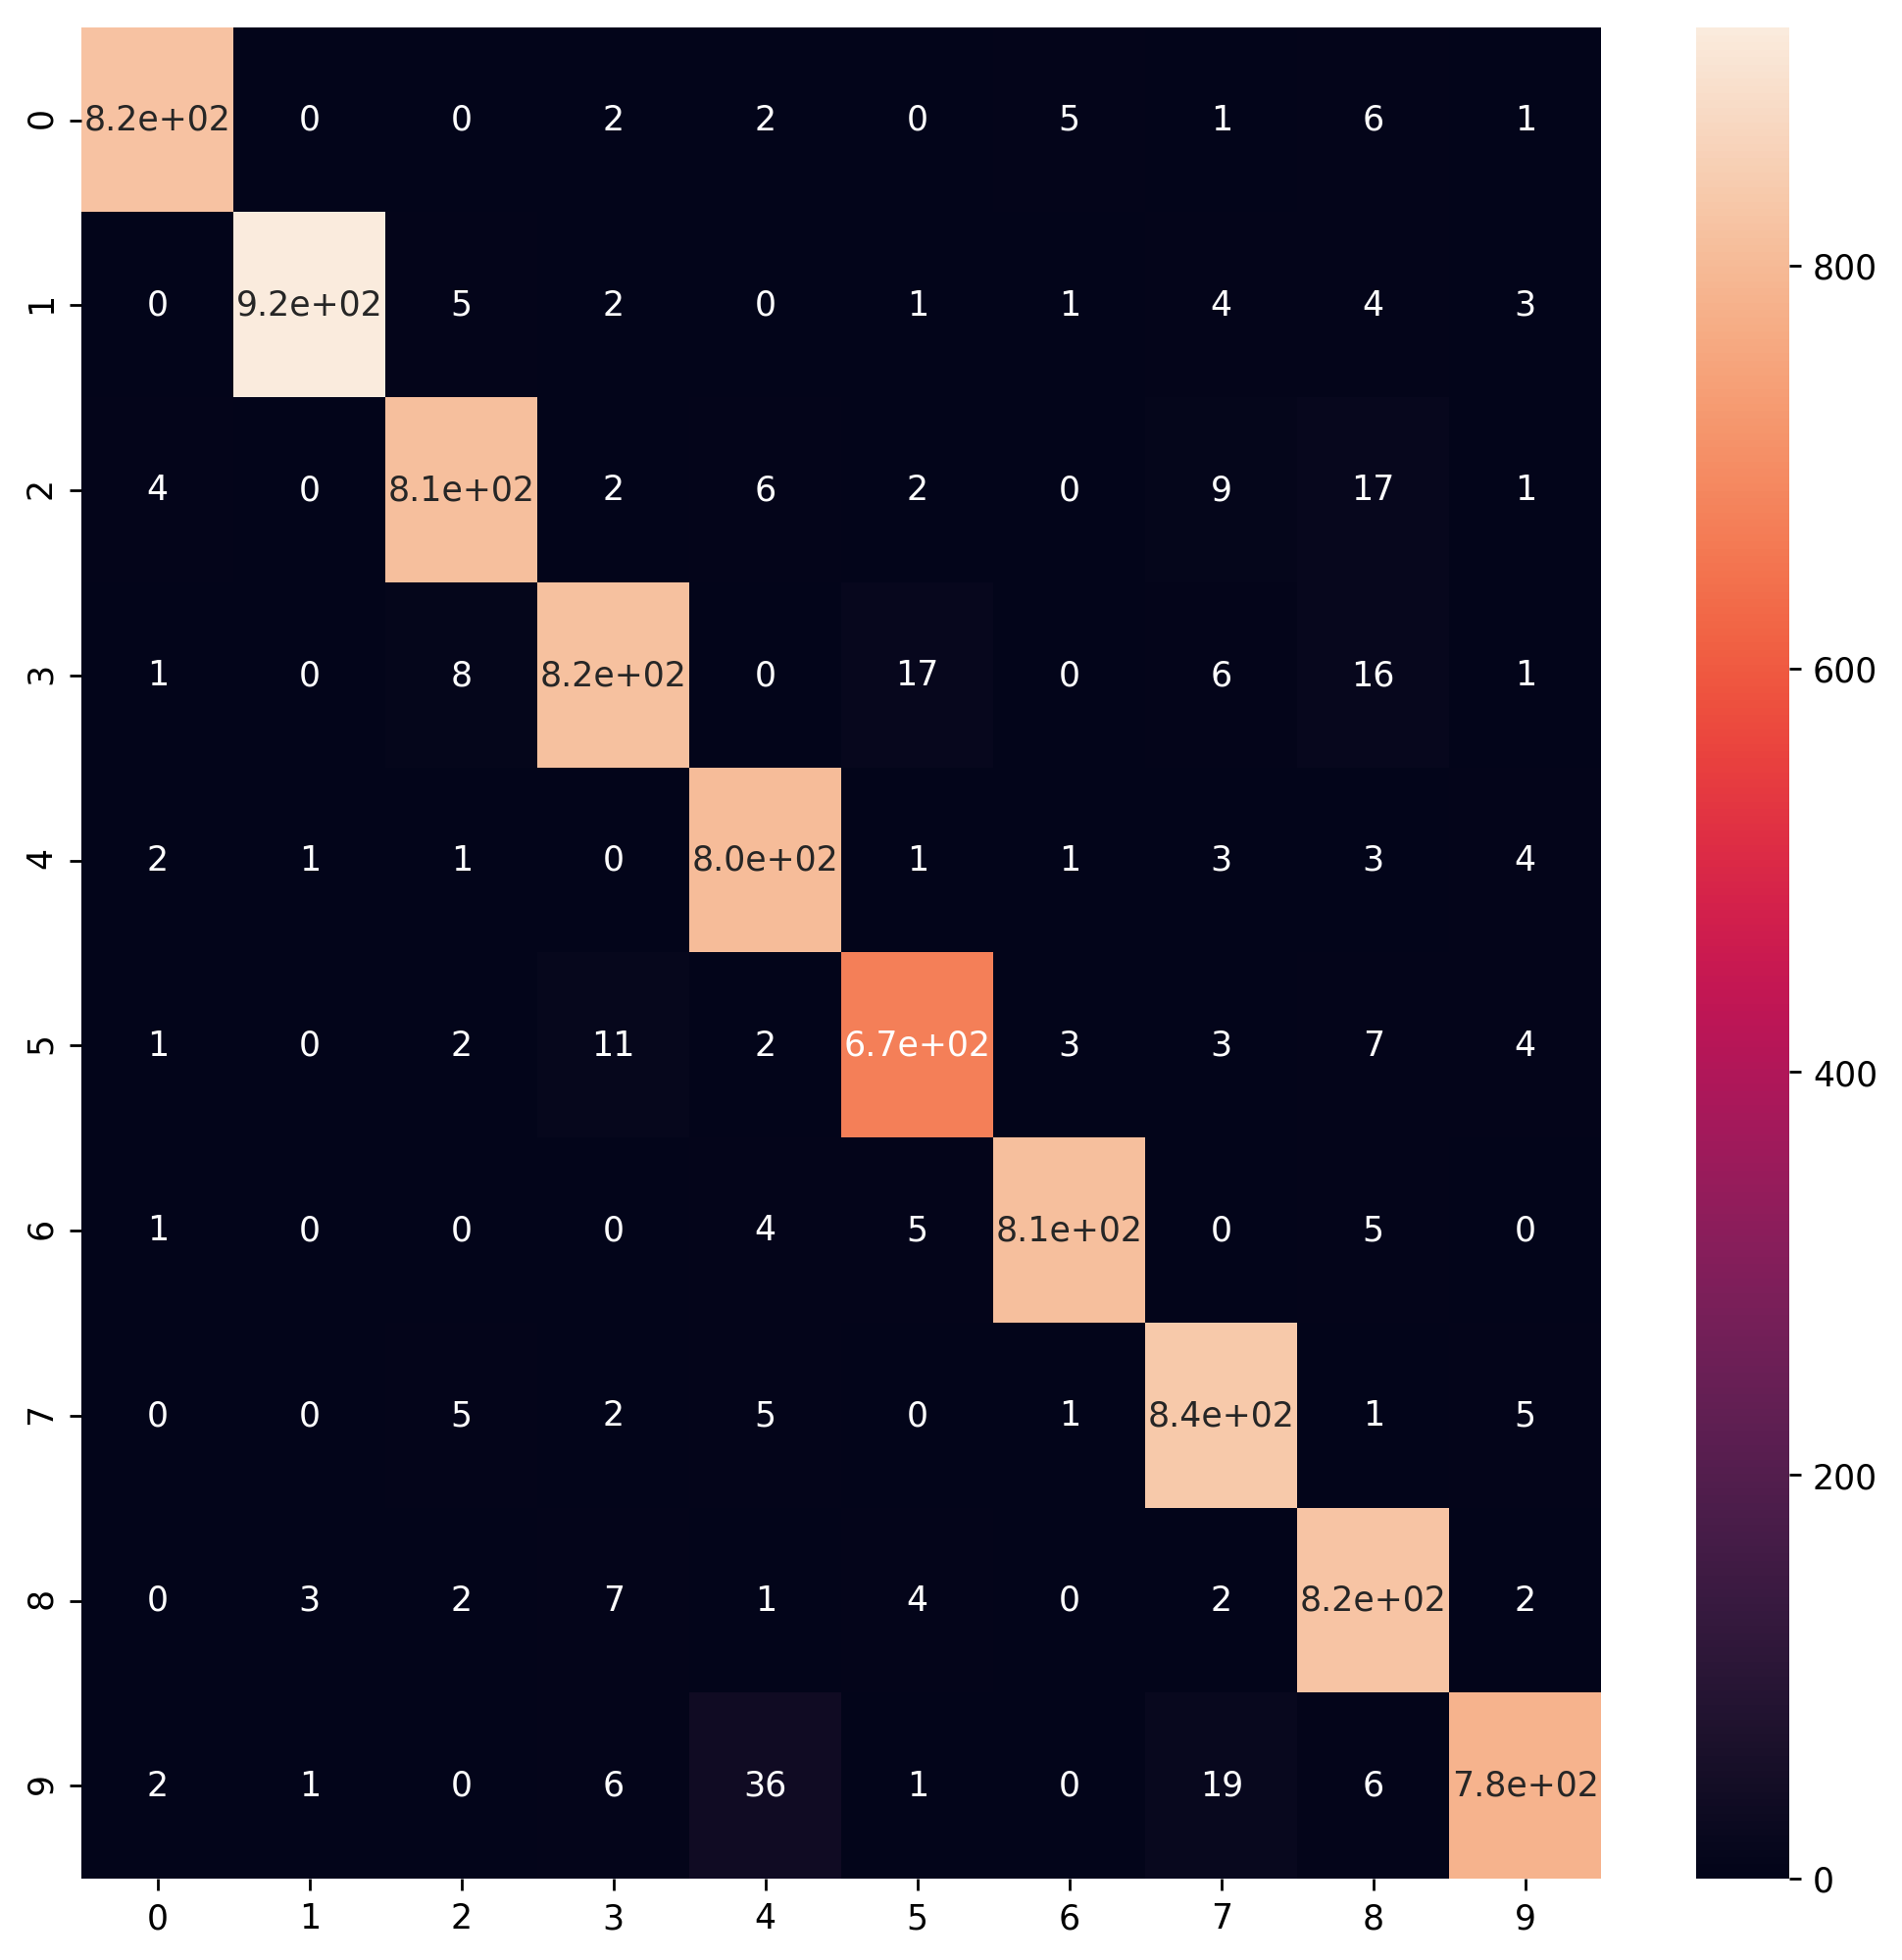

In [17]:
plt.figure(figsize = (10,10),dpi=250)
seaborn.heatmap(cm,annot=True)

In [18]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(val_y.asnumpy(),predictions)

print("Accuracy:",acc*100,"%")

Accuracy: 96.4047619048 %
